In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import gym
from gym import spaces
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

# Reading the Dataset

In [ ]:
# Loading the dataset
data = pd.read_csv('Metrics.csv')

In [ ]:
numeric_cols = ['Sharpe Ratio', 'Beta', 'Risk', 'Returns']
tickers = data['Ticker']
prices = data['Close']
data = data[numeric_cols]
data = data.astype(float)

In [ ]:
# Normalizing the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data, columns=numeric_cols)

# Stock Selection Environment

In [ ]:
class StockSelectionEnv(gym.Env):
    def __init__(self, data, prices, initial_amount=10000):
        super(StockSelectionEnv, self).__init__()
        self.data = data
        self.prices = prices
        self.initial_amount = initial_amount
        self.current_step = 0
        self.done = False
        self.action_space = spaces.Discrete(len(data))
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)
        self.reset()

    def reset(self):
        self.current_step = 0
        self.done = False
        self.current_amount = self.initial_amount
        return self._next_observation()

    def _next_observation(self):
        return self.data.iloc[self.current_step].values.astype(np.float32)

    def step(self, action):
        if self.done:
            return self._next_observation(), 0, self.done, {}

        # Get selected stock information
        stock = self.data.iloc[action]
        price = self.prices.iloc[action]
        risk = stock['Risk']

        # Calculate total risk of all available stocks
        total_risk = self.data['Risk'].sum()

        # Calculate proportionate investment based on risk relative to total risk
        if total_risk > 0:
            proportionate_investment = self.current_amount * (risk / total_risk)
        else:
            proportionate_investment = 0

        # Cap the investment amount to not exceed available funds
        investment = min(proportionate_investment, self.current_amount)

        # Calculate number of shares to buy based on the price
        if price > 0:
            num_shares_float = investment / price
            num_shares = int(num_shares_float)  # Convert to integer shares
        else:
            num_shares = 0

        # Calculate reward based on stock returns
        reward = num_shares * price * (1 + stock['Returns']) - investment

        # Add a penalty for unused funds to encourage full investment
        penalty = (self.initial_amount - self.current_amount) * 0.01

        reward -= penalty

        # Update current amount after investment
        self.current_amount -= investment

        # Move to the next step
        self.current_step += 1

        # Check termination conditions
        if self.current_step >= len(self.data) or self.current_amount <= 0:
            self.done = True

        return self._next_observation(), reward, self.done, {}

# Deep Q Network

In [ ]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 48)
        self.fc2 = nn.Linear(48, 48)
        self.fc3 = nn.Linear(48, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=5000)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
        self.recommended_stocks = []

    def remember(self, state, action, reward, next_state, done):
        state = np.asarray(state, dtype=np.float32)
        next_state = np.asarray(next_state, dtype=np.float32)
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state)
        with torch.no_grad():
            act_values = self.model(state)
        return torch.argmax(act_values).item()

    def get_q_values(self, state):
        state = torch.FloatTensor(state)
        with torch.no_grad():
            return self.model(state).numpy()

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state).unsqueeze(0)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)
            target = reward
            if not done:
                target += self.gamma * torch.max(self.model(next_state)).item()
            target_f = self.model(state)
            target_f = target_f.squeeze().detach().clone()
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = self.criterion(self.model(state), target_f.unsqueeze(0))
            loss.backward()
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [ ]:
num_states = 4
num_actions = len(data)
state_names = ['Sharpe Ratio', 'Beta', 'Risk', 'Returns']
action_names = tickers.tolist()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(f"Number of States: {num_states}")
print("State Names:", state_names)
print(f"Number of Actions: {num_actions}")
print("Action Names:", action_names[:10])

Number of States: 4
State Names: ['Sharpe Ratio', 'Beta', 'Risk', 'Returns']
Number of Actions: 1114
Action Names: ['20MICRONS.NS', '3IINFOLTD.NS', '3MINDIA.NS', '3PLAND.NS', '63MOONS.NS', 'A2ZINFRA.NS', 'AARTIDRUGS.NS', 'AARTIIND.NS', 'AARVEEDEN.NS', 'ABAN.NS']


In [ ]:
num_stocks = 10  # Number of stocks to recommend
initial_investment_amount = 1000000

# Risk Categorization

In [ ]:
low_risk_threshold = data['Risk'].quantile(0.33)
high_risk_threshold = data['Risk'].quantile(0.66)

# Function to categorize risk
def categorize_risk(risk_value):
    if risk_value <= low_risk_threshold:
        return 'Low'
    elif risk_value <= high_risk_threshold:
        return 'Medium'
    else:
        return 'High'

In [ ]:
def adjust_stock_numbers(initial_amount):
    if initial_amount < 50000:
        num_low_risk = int(num_stocks * 0.9)
        num_medium_risk = int(num_stocks * 0.1)
        num_high_risk = 0
    elif initial_amount >= 50000 and initial_amount < 5000000:
        num_low_risk = int(num_stocks * 0.6)
        num_medium_risk = int(num_stocks * 0.2)
        num_high_risk = int(num_stocks * 0.2)
    else:
        num_low_risk = int(num_stocks * 0.1)
        num_medium_risk = int(num_stocks * 0.3)
        num_high_risk = num_stocks - num_low_risk - num_medium_risk
    return num_low_risk, num_medium_risk, num_high_risk

# Recommending Environment

In [ ]:
env = StockSelectionEnv(data, prices)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
sub_agents = [DQNAgent(state_size, action_size) for _ in range(5)]
final_agent = DQNAgent(state_size + 5 * action_size, action_size)

In [ ]:
episodes = 50
batch_size = 64

for e in range(episodes):
    print(f"Episode {e+1}/{episodes}")
    state = env.reset()
    state = np.reshape(state, [1, state_size])

    for time in range(100):
        sub_agent_actions = []
        sub_agent_q_values = []
        for sub_agent in sub_agents:
            action = sub_agent.act(state)
            action = max(0, min(action, action_size - 1))
            sub_agent_actions.append(action)
            sub_agent_q_values.append(sub_agent.get_q_values(state).flatten())
            next_state, reward, done, _ = env.step(action)
            reward = reward if not done else -10
            next_state = np.reshape(next_state, [1, state_size])
            sub_agent.remember(state, action, reward, next_state, done)
            state = next_state

            if done:
                break

            if len(sub_agent.memory) > batch_size:
                sub_agent.replay(batch_size)

        state = env.reset()

        final_state_input = np.concatenate([state.flatten()] + sub_agent_q_values, axis=0)
        final_action = final_agent.act(final_state_input)
        print(f"Sub-agent Actions: {sub_agent_actions}, Final Action: {final_action} ({action_names[final_action]})")

        if done:
            print(f"Episode {e+1}/{episodes}, score: {time}, epsilon: {final_agent.epsilon:.2}")
            break

    if e % 2 == 0:  # Recommending stocks per 2 episodes
        recommended_stocks = []
        total_allocated_amount = 0
        recommended_indices = []

        sharpe_ratios = []

        num_low_risk, num_medium_risk, num_high_risk = adjust_stock_numbers(initial_investment_amount)

        for _ in range(num_low_risk):
            while True:
                stock_idx = final_agent.act(final_state_input)
                stock_idx = max(0, min(stock_idx, action_size - 1))  # Ensure the action is within bounds
                if stock_idx not in recommended_indices and categorize_risk(data.iloc[stock_idx]['Risk']) == 'Low':
                    recommended_indices.append(stock_idx)
                    sharpe_ratios.append(data.iloc[stock_idx]['Sharpe Ratio'])
                    break

        for _ in range(num_medium_risk):
            while True:
                stock_idx = final_agent.act(final_state_input)
                stock_idx = max(0, min(stock_idx, action_size - 1))  # Ensure the action is within bounds
                if stock_idx not in recommended_indices and categorize_risk(data.iloc[stock_idx]['Risk']) == 'Medium':
                    recommended_indices.append(stock_idx)
                    sharpe_ratios.append(data.iloc[stock_idx]['Sharpe Ratio'])
                    break

        for _ in range(num_high_risk):
            while True:
                stock_idx = final_agent.act(final_state_input)
                stock_idx = max(0, min(stock_idx, action_size - 1))  # Ensure the action is within bounds
                if stock_idx not in recommended_indices and categorize_risk(data.iloc[stock_idx]['Risk']) == 'High':
                    recommended_indices.append(stock_idx)
                    sharpe_ratios.append(data.iloc[stock_idx]['Sharpe Ratio'])
                    break

        total_sharpe_ratio = sum(sharpe_ratios)

        total_portfolio_return = 0

        for stock_idx, sharpe_ratio in zip(recommended_indices, sharpe_ratios):
            ticker = tickers.iloc[stock_idx]
            stock_return = data.iloc[stock_idx]['Returns']
            price = prices.iloc[stock_idx]

            if total_sharpe_ratio > 0:
                proportionate_investment = initial_investment_amount * (sharpe_ratio / total_sharpe_ratio)
            else:
                proportionate_investment = 0


            num_shares_float = proportionate_investment / price
            num_shares = int(num_shares_float)

            investment_amount_allocated = num_shares * price
            total_return = num_shares * price * (1.0 + stock_return) - investment_amount_allocated
            total_portfolio_return += total_return

            risk_category = categorize_risk(data.iloc[stock_idx]['Risk'])

            return_percentage = (total_return / investment_amount_allocated) * 100 if investment_amount_allocated > 0 else 0

            recommended_stocks.append({
                'Ticker': ticker,
                'Price': price,
                'Shares': num_shares,
                'Investment Amount Allocated': investment_amount_allocated,
                'Return Amount': total_return,
                'Risk Category': risk_category,
                'Return Percentage': return_percentage
            })

        final_agent.recommended_stocks.append({
            'stocks': recommended_stocks,
            'total_portfolio_return': total_portfolio_return
        })
final_recommendation = final_agent.recommended_stocks[-1]
final_recommended_stocks = final_recommendation['stocks']
total_portfolio_return = final_recommendation['total_portfolio_return']
recommended_stocks_df = pd.DataFrame(final_recommended_stocks)
print(f"Recommended top {num_stocks} stocks after training:")
print(recommended_stocks_df)
print(f"Total Portfolio Return: {total_portfolio_return}")

p_p = total_portfolio_return * 100 / initial_investment_amount
print(f"Total Portfolio Return Percentage: {p_p} %")

# Save recommended stocks and total portfolio return to a CSV file
recommended_stocks_df.to_csv('Recommendation_stock_High.csv', index=False)
with open('total_portfolio_return.txt', 'w') as f:
    f.write(f"Total Portfolio Return: {total_portfolio_return}")


Episode 1/50
Sub-agent Actions: [683, 173, 859, 601, 28], Final Action: 568 (KRITI.NS)
Sub-agent Actions: [175, 434, 1046, 380, 613], Final Action: 879 (SHAHALLOYS.NS)
Sub-agent Actions: [1020, 567, 837, 179, 606], Final Action: 1068 (VISAKAIND.NS)
Sub-agent Actions: [595, 1004, 398, 407, 547], Final Action: 792 (RAJSREESUG.NS)
Sub-agent Actions: [705, 542, 840, 638, 979], Final Action: 548 (KILITCH.NS)
Sub-agent Actions: [353, 61, 38, 59, 1021], Final Action: 132 (BERGEPAINT.NS)
Sub-agent Actions: [1027, 841, 732, 827, 872], Final Action: 32 (AKZOINDIA.NS)
Sub-agent Actions: [524, 201, 464, 288, 168], Final Action: 711 (ONMOBILE.NS)
Sub-agent Actions: [426, 207, 733, 194, 5], Final Action: 680 (NEULANDLAB.NS)
Sub-agent Actions: [816, 304, 426, 117, 152], Final Action: 1007 (TNPL.NS)
Sub-agent Actions: [48, 657, 335, 713, 389], Final Action: 636 (MOIL.NS)
Sub-agent Actions: [187, 835, 913, 936, 420], Final Action: 955 (SWARAJENG.NS)
Sub-agent Actions: [860, 46, 162, 955, 1028], Final A

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1114])) that is different to the input size (torch.Size([1, 1, 1114])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Streaming output truncated to the last 5000 lines.
Sub-agent Actions: [170, 803, 874, 1099, 207], Final Action: 551 (KIRLOSBROS.NS)
Sub-agent Actions: [1087, 1073, 406, 1107, 526], Final Action: 853 (SALSTEEL.NS)
Sub-agent Actions: [254, 241, 659, 11, 336], Final Action: 713 (ORCHPHARMA.NS)
Sub-agent Actions: [51, 939, 996, 251, 978], Final Action: 476 (ITI.NS)
Sub-agent Actions: [137, 997, 736, 836, 849], Final Action: 979 (TDPOWERSYS.NS)
Sub-agent Actions: [482, 411, 1109, 695, 442], Final Action: 1011 (TORNTPOWER.NS)
Sub-agent Actions: [587, 411, 602, 666, 990], Final Action: 300 (FEL.NS)
Sub-agent Actions: [1079, 922, 998, 243, 865], Final Action: 78 (ASIANHOTNR.NS)
Sub-agent Actions: [73, 578, 632, 308, 723], Final Action: 286 (ESSARSHPNG.NS)
Sub-agent Actions: [431, 384, 198, 909, 735], Final Action: 1110 (ZUARI.NS)
Sub-agent Actions: [396, 411, 172, 505, 1003], Final Action: 506 (JKPAPER.NS)
Sub-agent Actions: [586, 183, 618, 1064, 946], Final Action: 67 (AROGRANITE.NS)
Sub-agen

In [ ]:
recommended_stocks_df

,Ticker,Price,Shares,Investment Amount Allocated,Return Amount,Risk Category,Return Percentage
0,BBTC.NS,1543.557700,60,92613.46200,49000.076620,Low,52.908158
1,ICRA.NS,5444.279000,20,108885.58000,60513.130427,Low,55.574972
2,JKCEMENT.NS,3362.543000,28,94151.20400,49608.311893,Low,52.690045
3,BODALCHEM.NS,84.690620,781,66143.37422,28238.699205,Low,42.693164
4,DRREDDY.NS,5600.050000,17,95200.85000,50112.698687,Low,52.638919
5,ASTRAL.NS,1759.256000,60,105555.36000,58473.522145,Low,55.396071
6,IMFA.NS,472.981540,224,105947.86496,63930.140878,Medium,60.341132
7,JUSTDIAL.NS,802.002200,109,87418.23980,44330.692028,Medium,50.711033
8,ESSARSHPNG.NS,30.379270,3674,111613.43798,75505.466977,High,67.649083
9,TFL.NS,12.496686,9695,121155.37077,88510.904019,High,73.055700


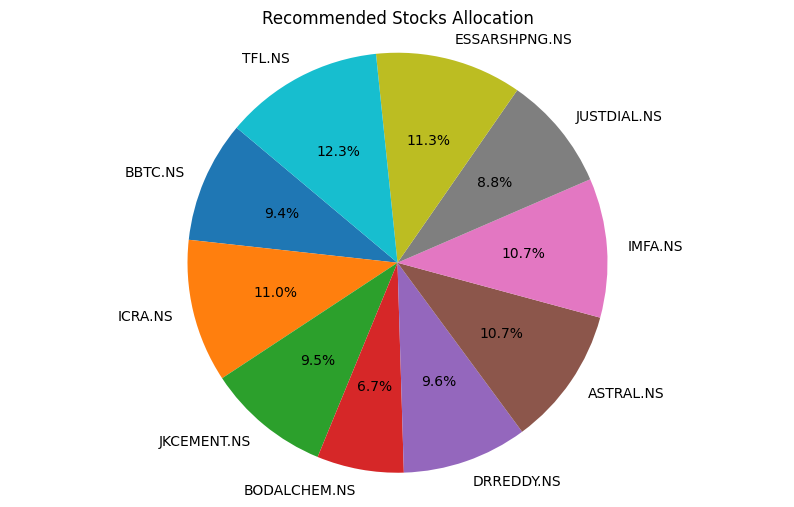

In [ ]:
investment_amounts = recommended_stocks_df['Investment Amount Allocated']
tickers = recommended_stocks_df['Ticker']
plt.figure(figsize=(10, 6))
plt.pie(investment_amounts, labels=tickers, autopct='%1.1f%%', startangle=140)
plt.title('Recommended Stocks Allocation')
plt.axis('equal')
plt.show()

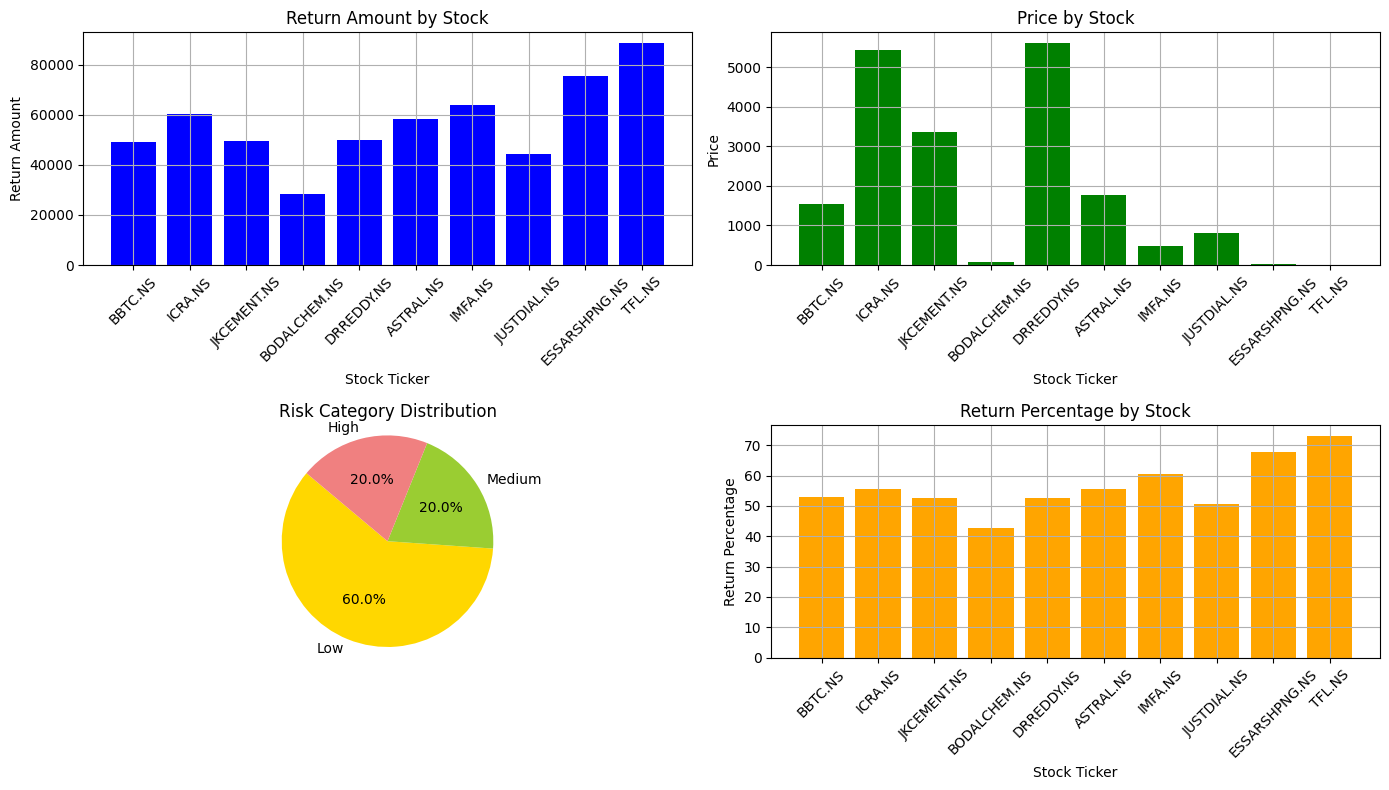

In [ ]:
recommended_stocks = final_recommendation['stocks']
tickers = [stock['Ticker'] for stock in recommended_stocks]
prices = [stock['Price'] for stock in recommended_stocks]
returns = [stock['Return Amount'] for stock in recommended_stocks]
risk_categories = [stock['Risk Category'] for stock in recommended_stocks]

plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
plt.bar(tickers, returns, color='blue')
plt.title('Return Amount by Stock')
plt.xlabel('Stock Ticker')
plt.ylabel('Return Amount')
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(2, 2, 2)
plt.bar(tickers, prices, color='green')
plt.title('Price by Stock')
plt.xlabel('Stock Ticker')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(2, 2, 3)
plt.pie([risk_categories.count('Low'), risk_categories.count('Medium'), risk_categories.count('High')],
        labels=['Low', 'Medium', 'High'],
        colors=['gold', 'yellowgreen', 'lightcoral'],
        autopct='%1.1f%%', startangle=140)
plt.title('Risk Category Distribution')
plt.axis('equal')

return_percentages = [stock['Return Percentage'] for stock in recommended_stocks]
plt.subplot(2, 2, 4)
plt.bar(tickers, return_percentages, color='orange')
plt.title('Return Percentage by Stock')
plt.xlabel('Stock Ticker')
plt.ylabel('Return Percentage')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()